# <font color='darkblue'> Monte Carlo calibration to synthetic data </font>

In [1]:
import signatory
import torch
#Call packages
import itertools as itt  
import iisignature
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import esig
import random
from matplotlib.pyplot import cm
import math
from functools import partial
from bokeh.io import show, output_notebook
from bokeh.layouts import row
from bokeh.plotting import figure, show
from bokeh.layouts import column
import pandas as pd
from sklearn.metrics import mean_squared_error 
from bokeh.embed import file_html
import chart_studio.plotly as py
import time as tm
from scipy.integrate import quad
from bokeh.models import Legend
import cmath
import numpy as np
import matplotlib.pyplot as plt
from math import isnan
from scipy.optimize import bisect, least_squares, minimize_scalar, minimize
import os
from sklearn.metrics import mean_squared_error
from py_vollib.ref_python.black_scholes_merton.implied_volatility import implied_volatility
from py_vollib.ref_python.black_scholes_merton.implied_volatility import black_scholes_merton
from scipy.stats import norm

In [3]:

output_notebook()


Loading BokehJS ...

### <font color='darkblue'> In the following chunk various functions are implemented to simulate IV under an Heston model and to compute the Implied volatility of an option price </font>

In [5]:
def duplicate(testList, n):
    x=[list(testList) for _ in range(n)]
    flat_list = []
    for sublist in x:
        for item in sublist:
            flat_list.append(item)
    return flat_list

def Heston_P_Value(hestonParams,r,T,s0,K,typ):
    kappa, theta, sigma, rho, v0 = hestonParams
    return 0.5+(1./np.pi)*quad(lambda xi: Int_Function_1(xi,kappa,theta, sigma,rho,v0,r,T,s0,K,typ),0.,500.)[0]

def Int_Function_1(xi,kappa,theta,sigma,rho,v0,r,T,s0,K,typ):
    return (cmath.e**(-1j*xi*np.log(K))*Int_Function_2(xi,kappa,theta,sigma,rho,v0,r,T,s0,typ)/(1j*xi)).real

def Int_Function_2(xi,kappa,theta,sigma,rho,v0,r,T,s0,typ):
    if typ == 1:
        w = 1.
        b = kappa - rho*sigma
    else:
        w = -1.
        b = kappa
    ixi = 1j*xi
    d = cmath.sqrt((rho*sigma*ixi-b)*(rho*sigma*ixi-b) - sigma*sigma*(w*ixi-xi*xi))
    g = (b-rho*sigma*ixi-d) / (b-rho*sigma*ixi+d)
    ee = cmath.e**(-d*T)
    C = r*ixi*T + kappa*theta/(sigma*sigma)*((b-rho*sigma*ixi-d)*T - 2.*cmath.log((1.0-g*ee)/(1.-g)))
    D = ((b-rho*sigma*ixi-d)/(sigma*sigma))*(1.-ee)/(1.-g*ee)
    return cmath.e**(C + D*v0 + ixi*np.log(s0))

def phi(x): ## Gaussian density
    return np.exp(-x*x/2.)/np.sqrt(2*np.pi)

#### Black Sholes Vega
def BlackScholesVegaCore(DF,F,X,T,v):   #S=F*DF
    vsqrt=v*np.sqrt(T)
    d1 = (np.log(F/X)+(vsqrt*vsqrt/2.))/vsqrt
    return F*phi(d1)*np.sqrt(T)/DF

#### Black Sholes Function
def BlackScholesCore(CallPutFlag,DF,F,X,T,v):
    ## DF: discount factor
    ## F: Forward
    ## X: strike
    vsqrt=v*np.sqrt(T)
    d1 = (np.log(F/X)+(vsqrt*vsqrt/2.))/vsqrt
    d2 = d1-vsqrt
    if CallPutFlag:
        return DF*(F*norm.cdf(d1)-X*norm.cdf(d2))
    else:
        return DF*(X*norm.cdf(-d2)-F*norm.cdf(-d1))
    
##  Black-Scholes Pricing Function
def BlackScholes(CallPutFlag,S,X,T,r,d,v):
    ## r, d: continuous interest rate and dividend
    return BlackScholesCore(CallPutFlag,np.exp(-r*T),np.exp((r-d)*T)*S,X,T,v)

def heston_EuropeanCall(hestonParams,r,T,s0,K):
    a = s0*Heston_P_Value(hestonParams,r,T,s0,K,1)
    b = K*np.exp(-r*T)*Heston_P_Value(hestonParams,r,T,s0,K,2)
    return a-b

def heston_Vanilla(hestonParams,r,T,s0,K,flag):
    a_call = s0*Heston_P_Value(hestonParams,r,T,s0,K,1)
    b_call = K*np.exp(-r*T)*Heston_P_Value(hestonParams,r,T,s0,K,2)
    a_put = s0*(1-Heston_P_Value(hestonParams,r,T,s0,K,1))
    b_put = K*np.exp(-r*T)*(1-Heston_P_Value(hestonParams,r,T,s0,K,2))
    if flag=='call':
        return a_call-b_call
    if flag=='put':
        return b_put-a_put
    else:
        return print('You have chosen a flag which is not a Vanilla Option')
    

def heston_Impliedvol(hestonParams,r,T,s0,K):
    myPrice = heston_EuropeanCall(hestonParams,r,T,s0,K)
    ## Bisection algorithm when the Lee-Li algorithm breaks down
    def smileMin(vol, *args):
        K, s0, T, r, price = args
        return price - BlackScholes(True, s0, K, T, r, 0., vol)
    vMin = 0.000001
    vMax = 10.
    return bisect(smileMin, vMin, vMax, args=(K, s0, T, r, myPrice), rtol=1e-15, full_output=False, disp=True)

def phi(x): ## Gaussian density
    return np.exp(-x*x/2.)/np.sqrt(2*np.pi)


#### Black Sholes Vega
def BlackScholesVegaCore(DF,F,X,T,v):   #S=F*DF
    vsqrt=v*np.sqrt(T)
    d1 = (np.log(F/X)+(vsqrt*vsqrt/2.))/vsqrt
    return F*phi(d1)*np.sqrt(T)/DF

def implied_vol_minimize( price, S0, K, T, r, payoff="call", disp=True ):
    """ Returns Implied volatility by minimization"""
    
    n = 2     # must be even
    def obj_fun(vol):
        return ( BlackScholes(True, S0, K, T, r, 0., vol) - price)**n
        
    res = minimize_scalar( obj_fun, bounds=(1e-15, 8), method='bounded')
    if res.success == True:
        return res.x       
    if disp == True:
        print("Strike", K)
    return -1

### <font color='darkblue' > We consider first 9 strikes in the first configuration (as for the market option prices that we had), and then 13 strikes. The maturities are the same, i.e., they span from a minimum of 1 month to a maximum of 2 years. </font>

In [6]:
maturities=np.load('maturities_SPX_Bloomberg.npy') # np.array([0.10, 0.25, 0.5 , 1.])
moneynesses=[0.2,0.2,0.2,.2,0.2,.2,.2]
strikes=[]
nbr_strikes=9
S0=1
for moneyness in moneynesses:
    strikes.append(np.linspace(np.exp(-moneyness)*S0, np.exp(moneyness)*S0, nbr_strikes))
strikes=np.array(strikes)


In [7]:
strikes

array([[0.81873075, 0.86906475, 0.91939875, 0.96973275, 1.02006676,
        1.07040076, 1.12073476, 1.17106876, 1.22140276],
       [0.81873075, 0.86906475, 0.91939875, 0.96973275, 1.02006676,
        1.07040076, 1.12073476, 1.17106876, 1.22140276],
       [0.81873075, 0.86906475, 0.91939875, 0.96973275, 1.02006676,
        1.07040076, 1.12073476, 1.17106876, 1.22140276],
       [0.81873075, 0.86906475, 0.91939875, 0.96973275, 1.02006676,
        1.07040076, 1.12073476, 1.17106876, 1.22140276],
       [0.81873075, 0.86906475, 0.91939875, 0.96973275, 1.02006676,
        1.07040076, 1.12073476, 1.17106876, 1.22140276],
       [0.81873075, 0.86906475, 0.91939875, 0.96973275, 1.02006676,
        1.07040076, 1.12073476, 1.17106876, 1.22140276],
       [0.81873075, 0.86906475, 0.91939875, 0.96973275, 1.02006676,
        1.07040076, 1.12073476, 1.17106876, 1.22140276]])

In [8]:
#moneyness2=np.array([0.7,0.8,0.9,0.95,1,1.05,1.1,1.2,1.3])

In [9]:
moneyness=np.load('strikes_SPX_Bloomberg.npy')
strikes_all=duplicate(moneyness,len(maturities))
strikes=np.array([np.array(strikes_all[j*(len(moneyness)):(j+1)*(len(moneyness))]) for j in range(len(maturities))])

In [10]:
set_params={'alpha':0.4,'kappa':0.01,'theta':0.2,'rho':-0.5,'v0':0.08}
#set_params={'alpha':0.45,'kappa':0.05,'theta':0.25,'rho':-0.1,'v0':0.1}


#set_params={'alpha':0.55,'kappa':0.009,'theta':0.35,'rho':-0.5,'v0':0.1}

In [11]:
def get_iv_Heston_by_params(set_params,strikes,maturities,S0,nbr_strikes):
    'This function generates for the chosen parameters under Q of the Heston, the strikes and the maturities; the IV surface'
    r=0.
    index_selected_mat=range(len(maturities))

    hestonParams = set_params['kappa'], set_params['theta'], set_params['alpha'], set_params['rho'], set_params['v0'] 
    
    Heston_prices_calib_call=[]
    iv_call=[]
    for j in index_selected_mat:
        for strike in strikes[j]:
            he_p_call=heston_Vanilla(hestonParams,r,maturities[j],S0,strike,'call')
            Heston_prices_calib_call.append(he_p_call)
            iv_call.append(implied_volatility(he_p_call, S0, strike, maturities[j], 0, 0, 'c'))

    Heston_prices_calib_put=[]
    iv_put=[]
    for j in index_selected_mat:
        for strike in strikes[j]:
            he_p_put=heston_Vanilla(hestonParams,r,maturities[j],S0,strike,'put')
            Heston_prices_calib_put.append(he_p_put)
            iv_put.append(implied_volatility(he_p_put, S0, strike, maturities[j], 0, 0, 'p'))
            
    element_to_substitute=0

    Heston_prices_calib=[]

    for j in index_selected_mat:
        for k in range(len(strikes[j])):
            if (k<len(strikes[0])-element_to_substitute):
                Heston_prices_calib.append(heston_Vanilla(hestonParams,r,maturities[j],S0,strikes[j][k],'call'))
            else:
                Heston_prices_calib.append(heston_Vanilla(hestonParams,r,maturities[j],S0,strikes[j][k],'put'))
                
    %matplotlib inline
    fig1 = plt.figure(figsize=(12, 8))
    for j in range(len(maturities)):
        #plt.subplot(2, 2, j+1)
        plt.plot(strikes[j], iv_call[j*nbr_strikes:(j+1)*nbr_strikes],label='Maturity T={}'.format(round(maturities[j],4)),marker='o')
        plt.legend()
    plt.title('Generated Smiles')
    plt.show()
    
    np.array(np.split(np.array(iv_call),len(maturities)))
    %matplotlib inline

    # set up a figure twice as wide as it is tall
    fig = plt.figure(figsize=(15,8))
    ax = fig.add_subplot(1, 1, 1, projection='3d')

    YY=np.array([[maturities[j]]*(len(strikes[0])) for j in range(7)])
    ax.plot_surface(strikes, YY, np.array(np.split(np.array(iv_call),len(maturities))), rstride=1, cstride=1, cmap=cm.viridis,
                       linewidth=0.5)
    
    

    ax.set_xlabel('Strikes')
    ax.set_ylabel('Maturities')
    ax.set_zlabel('IV')
    ax.set_title('Implied Volatililty');

    plt.tight_layout()
    plt.show()
    
    return np.array(Heston_prices_calib), np.array(iv_call)


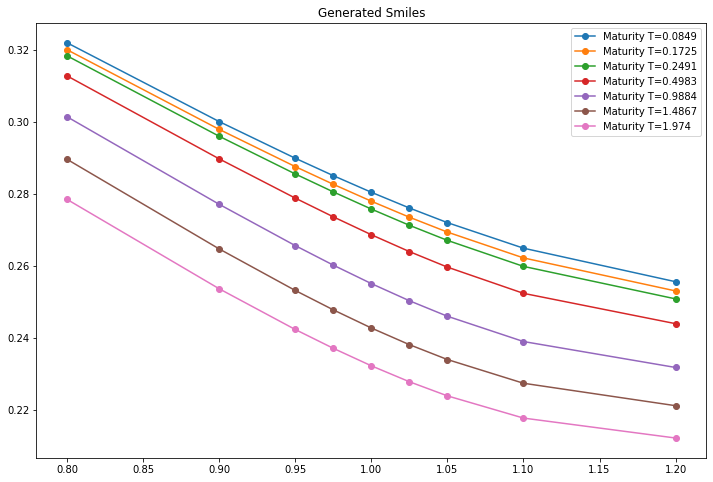

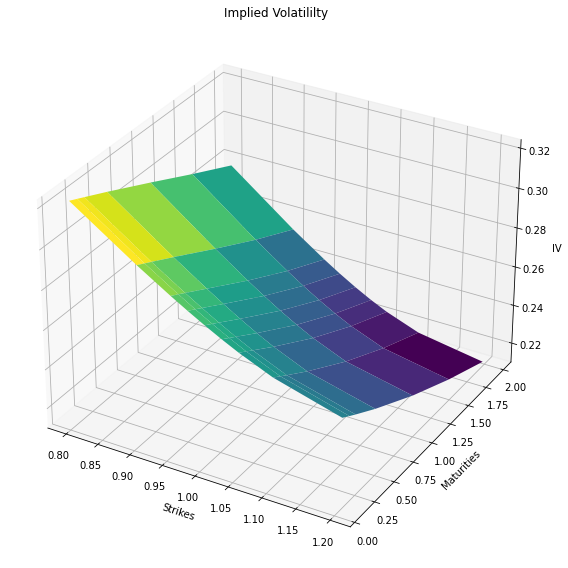

In [12]:
prices, iv= get_iv_Heston_by_params(set_params,strikes,maturities,S0,nbr_strikes)

In [265]:
iv_market=np.array(np.split(iv,len(maturities)))
prices_market=np.array(np.split(prices,len(maturities)))

In [261]:
def dimension_coef(order_Signature,d,D):
    'how many parameters to be calibrated'
    return int(((d+1)**(order_Signature)-1)*D/d)
d,D=2,1
dim=dimension_coef(order_Signature+1,d,D)
print(dim)

13


In [262]:
iv_calibrated=[]

## Calibration to option

Compute the vega weights

In [16]:
def get_vegas(maturities, strikes, initial_price, iv_market, flag_truncation):
    'Compute vega weights'
    vega=[]
    for i in range(len(maturities)):
        for j in range(len(strikes[i])):
            if flag_truncation==True:
                vega.append(min(1/(BlackScholesVegaCore(1,initial_price,strikes[i][j],maturities[i],iv_market[i,j])),1))
            else:
                vega.append(1/(BlackScholesVegaCore(1,initial_price,strikes[i][j],maturities[i],iv_market[i,j])))
    vega=np.array(vega)

    vega_by_mat=np.array(np.split(vega,len(maturities)))
    sums_each_strike=np.sum(vega_by_mat, axis=1)
    normalized_vega=np.array([vega_by_mat[j]/sums_each_strike[j] for j in range(len(maturities))])
    flat_normal_weights=normalized_vega.flatten()
    return flat_normal_weights, normalized_vega


#flag_truncation=False
#flat_normal_weights, norm_vegas=get_vegas(maturities, strikes, S0, iv_market, flag_truncation)


In [78]:
arr_dfs_by_mat=np.load('arr_dfs_by_mat((7, 1000000, 13)).npy')


(7, 1000000, 13)

# <font color='darkblue'> Configuration 1: </font>

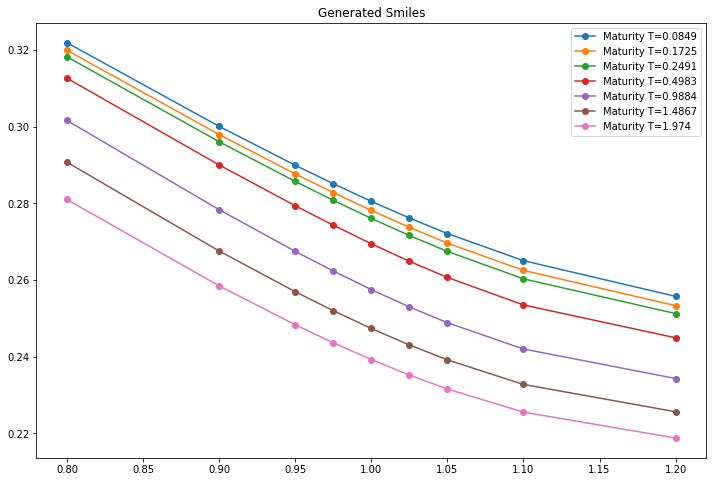

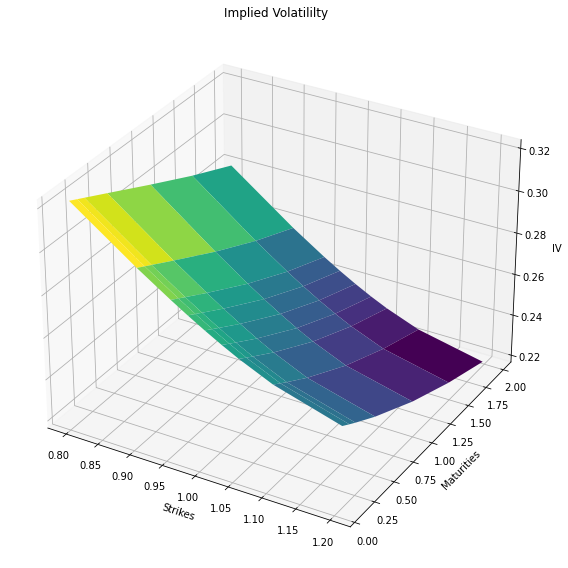

In [308]:
set_params={'alpha':0.4,'kappa':0.1,'theta':0.1,'rho':-0.5,'v0':0.08}
prices, iv= get_iv_Heston_by_params(set_params,strikes,maturities,S0,nbr_strikes)
iv_market=np.array(np.split(iv,len(maturities)))
prices_market=np.array(np.split(prices,len(maturities)))

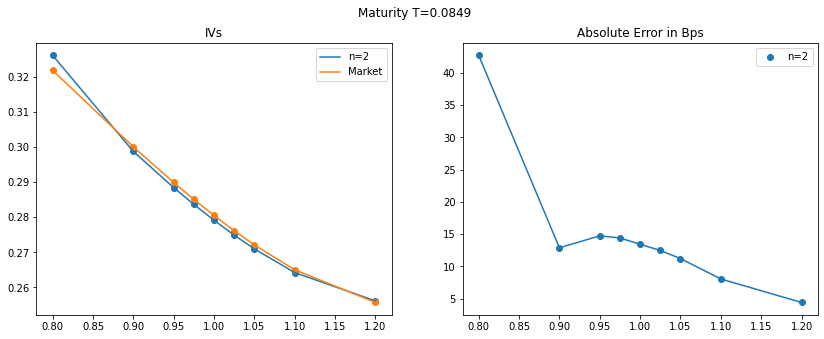

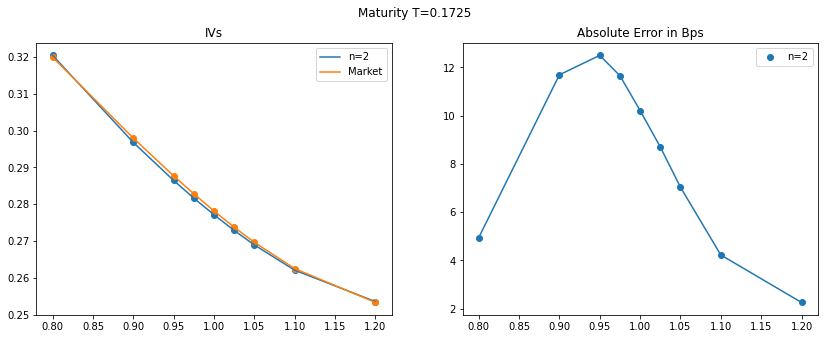

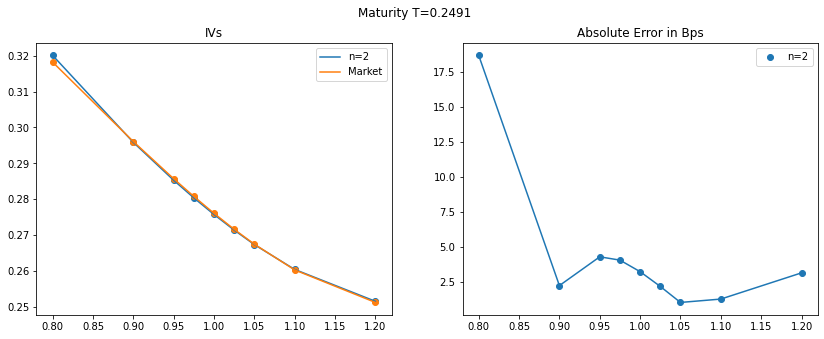

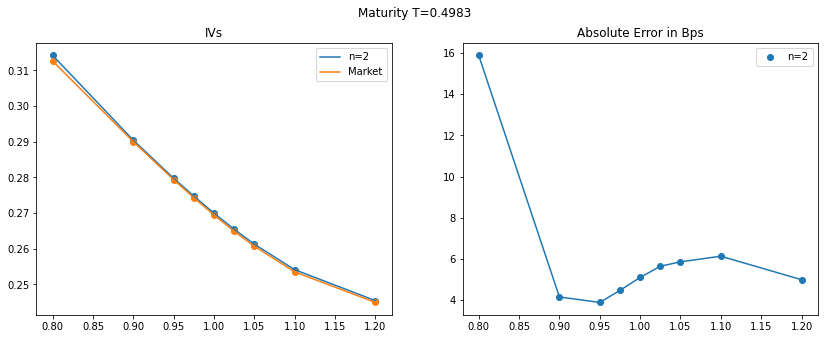

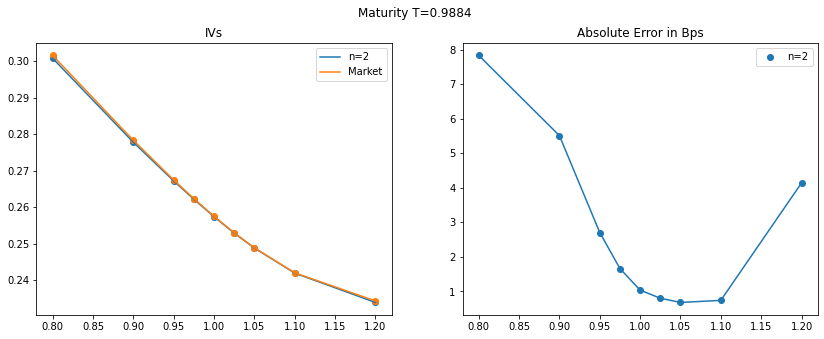

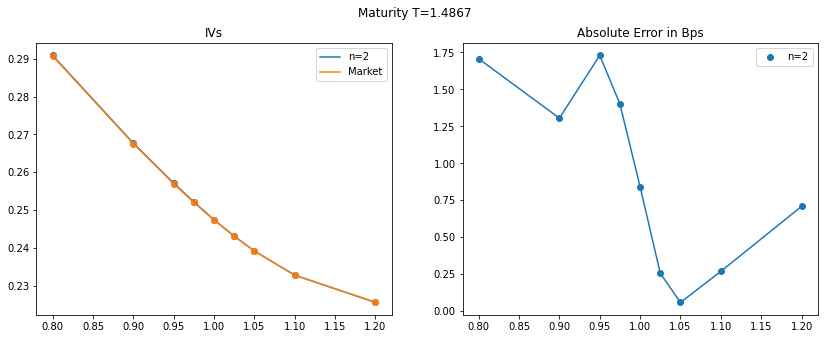

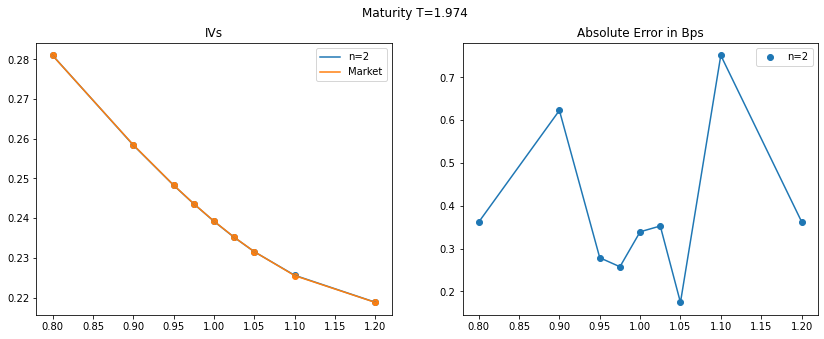

In [309]:
calibrated_prices_HE=np.load('calibrated_prices_MC_HE_new_config4(2,2000000,365,-0.5,1).npy')
ell_MC_HE=np.load('ell_MC_HE_new_config4(2,4,2,-0.5,2000000,1).npy')

#Invert IVS from option prices
norm_strikes=strikes
calibrated_prices1_arr=np.array(np.split(calibrated_prices_HE,len(maturities)))

iv_calib_mc1=[]

for j in range(len(maturities)):
    for k in range(9):
        iv_calib_mc1.append(implied_vol_minimize(calibrated_prices1_arr[j,k], 1, norm_strikes[j][k], maturities[j], 0, payoff="call", disp=True))
        
        
iv_calib_mc1_arr=np.array(np.split(np.array(iv_calib_mc1),len(maturities)))


for j in range(len(maturities)):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
    fig.suptitle('Maturity T={}'.format(round(maturities[j],4)))
    ax1.plot(strikes[j], iv_calib_mc1_arr[j],label='n=2')
    ax1.scatter(strikes[j], iv_calib_mc1_arr[j])
    ax1.plot(strikes[j], iv_market[j],label='Market')
    ax1.scatter(strikes[j], iv_market[j])
    ax2.plot(strikes[j],np.abs(iv_calib_mc1_arr[j]-iv_market[j])*10000)
    ax2.scatter(strikes[j],np.abs(iv_calib_mc1_arr[j]-iv_market[j])*10000,label='n=2')
    
    
    ax1.legend(loc='upper right')
    ax2.legend(loc='upper right')
    
    ax1.set_title('IVs')
    ax2.set_title('Absolute Error in Bps')
    
    plt.show()

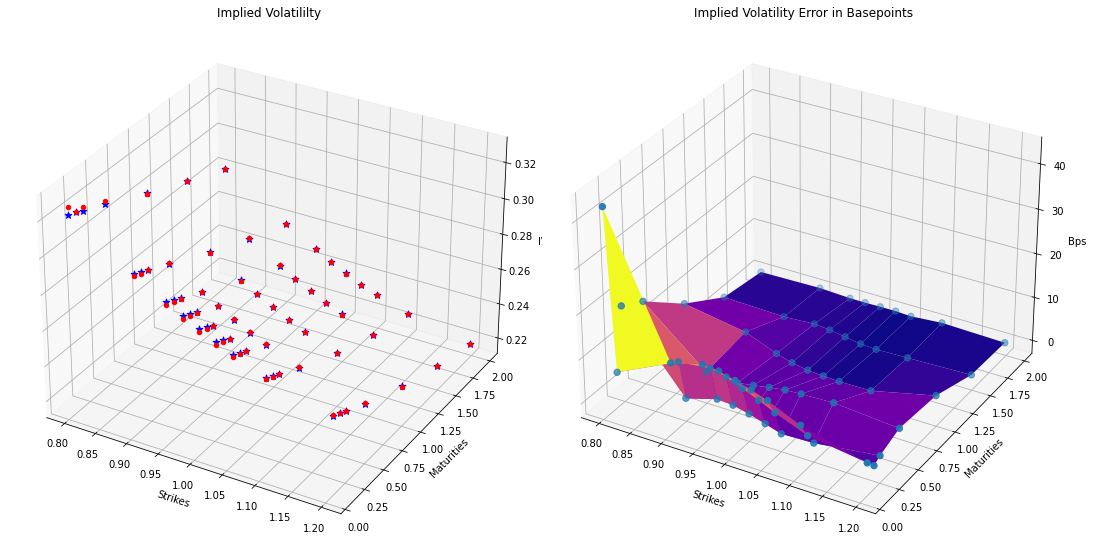

In [312]:
%matplotlib inline

# set up a figure twice as wide as it is tall
fig = plt.figure(figsize=(15,8))

# =============
# First subplot
# =============
# set up the axes for the first plot
ax = fig.add_subplot(1, 2, 1, projection='3d')

#surf = ax.plot_surface(strikes, YY, iv_market, rstride=1, cstride=1, cmap=cm.viridis,
#                       linewidth=0.5)
YY=np.array([[maturities[j]]*(len(strikes[0])) for j in range(7)])
ax.scatter(strikes, YY, iv_market,s=50,marker='*',color='blue',depthshade=False)
ax.scatter(strikes, YY, iv_calib_mc1_arr, s=20,marker='o',color='red',depthshade=False)



ax.set_xlabel('Strikes')
ax.set_ylabel('Maturities')
ax.set_zlabel('IV')
ax.set_title('Implied Volatililty');


# ==============
# Second subplot
# ==============
# set up the axes for the second plot
ax = fig.add_subplot(1, 2, 2, projection='3d')
# plot a 3D wireframe like in the example mplot3d/wire3d_demo
ax.plot_surface(strikes, YY, np.abs(np.array(iv_calib_mc1_arr)-iv_market)*10000, rstride=1, cstride=1,cmap=cm.plasma,
                       linewidth=0.5)
ax.scatter(strikes, YY, np.abs(np.array(iv_calib_mc1_arr)-iv_market)*10000,s=40)

ax.set_xlabel('Strikes')
ax.set_ylabel('Maturities')
ax.set_zlabel('Bps')
ax.set_title('Implied Volatility Error in Basepoints');

#plt.savefig('IV_surface_jointcalibration.png',dpi=150)
plt.tight_layout()
plt.show()

# <font color='darkblue'> Configuration 2: </font>

In [23]:
strikes_new=np.array([np.array([0.8,0.85,0.9,0.925,0.95,0.975,1,1.025,1.05,1.075,1.1,1.15,1.2]) for k in range(7)])

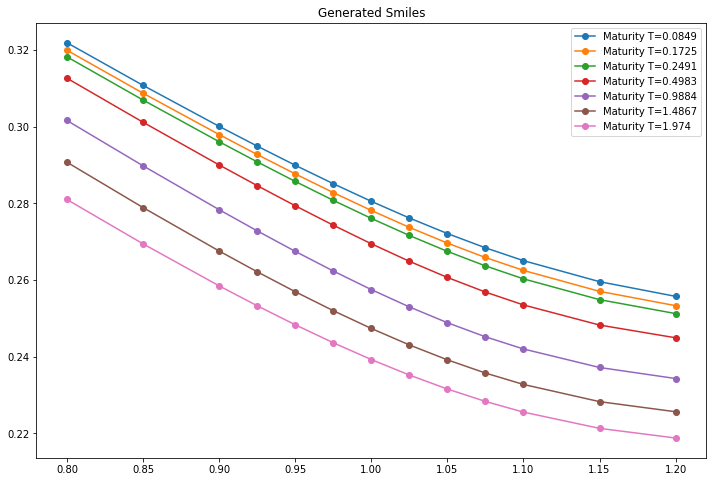

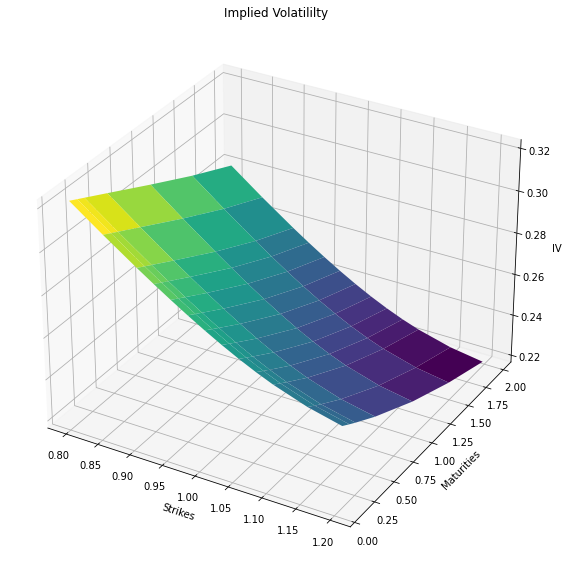

In [50]:
set_params={'alpha':0.4,'kappa':0.1,'theta':0.1,'rho':-0.5,'v0':0.08}
prices, iv= get_iv_Heston_by_params(set_params,strikes_new,maturities,S0,len(strikes_new[0]))
iv_market=np.array(np.split(iv,len(maturities)))
prices_market=np.array(np.split(prices,len(maturities)))

In [25]:
flat_normal_weights, norm_vegas=get_vegas(maturities, strikes_new, S0, iv_market, False)

In [327]:
os.chdir(r'C:\Users\Guido Gazzani\ucloud\Shared\SigSDEs_ucloud\Code_real_data\Cluster_files')
arr_dfs_by_mat=np.load('arr_dfs_by_mat((7, 1000000, 13)).npy')

In [339]:
n=2
d=2
D=1
initial_price=1
Premium=prices_market.flatten()
l_initial=np.random.uniform(-0.1,0.1,int(((d+1)**(n+1)-1)*D/d))


tensor_sigsde_at_mat=np.tensordot(arr_dfs_by_mat,l_initial,axes=1) #computes the value S_T(ell) for all mat for a fixed ell


def obj_MC_tensor(l):
    'Objective functional to be mimized, returns a vector fitting with the least_squares function of Python'
    tensor_sigsde_at_mat=np.tensordot(arr_dfs_by_mat,l,axes=1)+initial_price #veloce
    
       # this part computes the monte carlo prices of the calls ---> output: mc_payoff_arr (quite fast)
    pay=[]
    for K in strikes_new[0]:
        matrix_big=[]
        for j in range(len(maturities)):
            payff=np.maximum(0, tensor_sigsde_at_mat[j] - K)
            matrix_big.append(payff)
        matrix=np.array(matrix_big)
        pay.append(np.mean(matrix,axis=1))
    mc_payoff_arr=np.array(pay).transpose().flatten()
    
    
    return np.sqrt(flat_normal_weights)*(mc_payoff_arr-Premium)



for t in tqdm(range(1)): 
    l_initial=np.random.uniform(-0.1,0.1,int(((d+1)**(n+1)-1)*D/d))
    res1 = least_squares(obj_MC_tensor, l_initial,loss='linear')


def get_mc_all_mat_tensor(l):
    'Return all MC prices'
    tensor_sigsde_at_mat=np.tensordot(arr_dfs_by_mat,l,axes=1)+initial_price
    pay=[]
    for K in strikes_new[0]:
        matrix_big=[]
        for j in range(len(maturities)):
            payff=np.maximum(0, tensor_sigsde_at_mat[j] - K)
            matrix_big.append(payff)
        matrix=np.array(matrix_big)
        pay.append(np.mean(matrix,axis=1))
    mc_payoff_arr=np.array(pay).transpose().flatten()
    return mc_payoff_arr



calibrated_prices=get_mc_all_mat_tensor(res1['x'])



  0%|          | 0/1 [00:00<?, ?it/s]

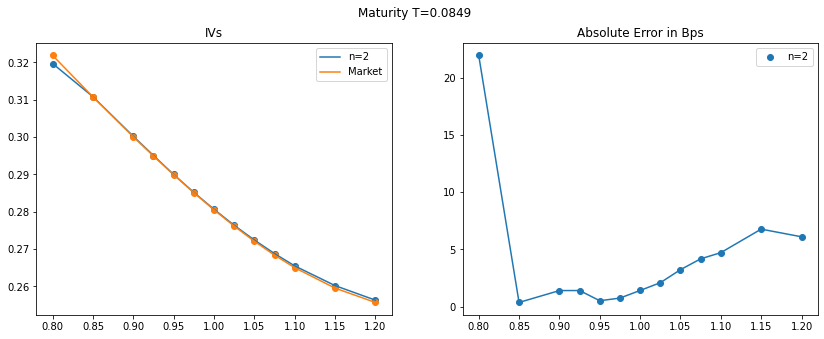

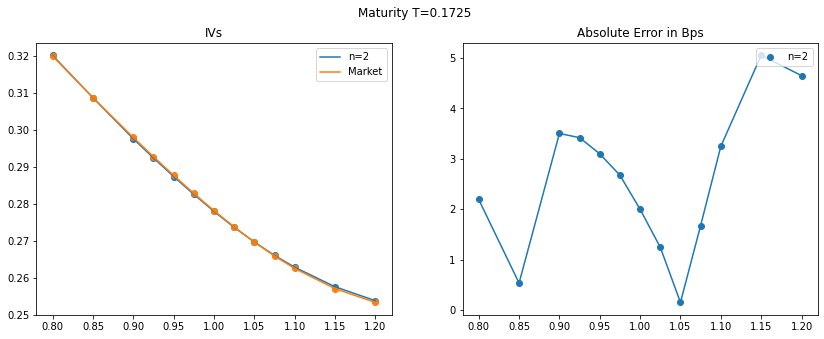

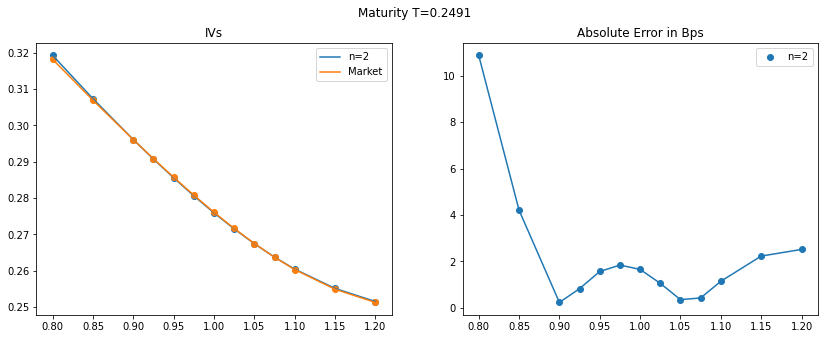

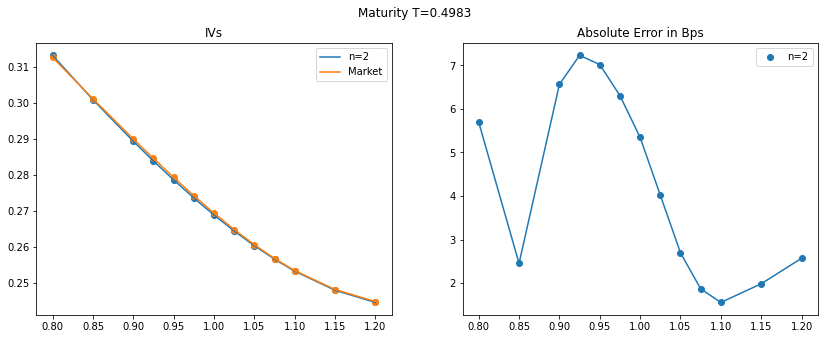

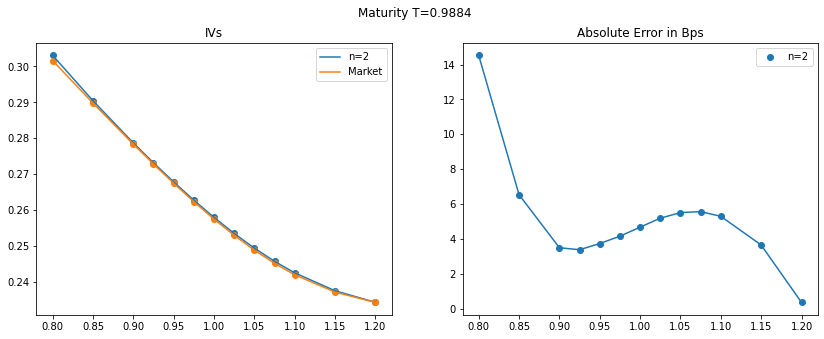

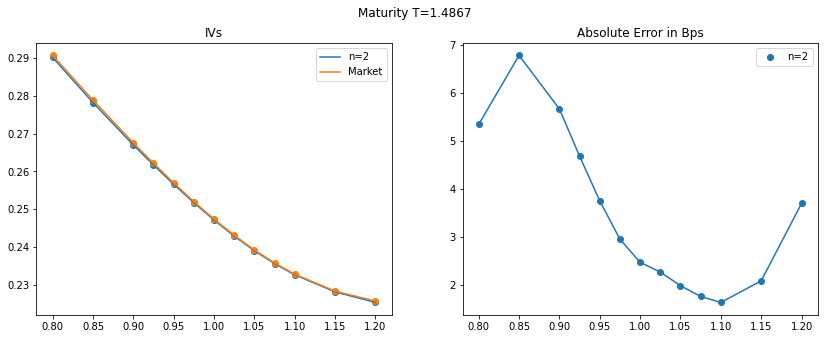

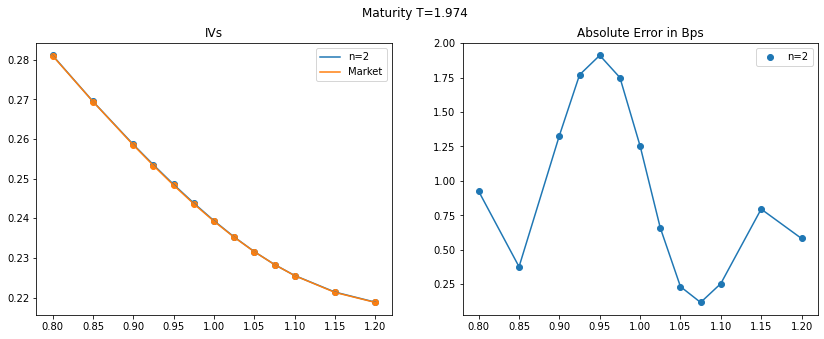

In [51]:
norm_strikes=strikes_new
#calibrated_prices1_arr=np.array(np.split(calibrated_prices,len(maturities)))

os.chdir(r'C:\Users\Guido Gazzani\ucloud\Shared\SigSDEs_ucloud\Code_joint_calibration')

calibrated_prices1_arr=np.load('pricescalib_MC_HE_ipynb(2,4,2,1000000,config5).npy')

iv_calib_mc1=[]

for j in range(len(maturities)):
    for k in range(len(strikes_new[0])):
        iv_calib_mc1.append(implied_vol_minimize(calibrated_prices1_arr[j,k], 1, norm_strikes[j][k], maturities[j], 0, payoff="call", disp=True))
        
        
iv_calib_mc1_arr=np.array(np.split(np.array(iv_calib_mc1),len(maturities)))


for j in range(len(maturities)):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
    fig.suptitle('Maturity T={}'.format(round(maturities[j],4)))
    ax1.plot(strikes_new[j], iv_calib_mc1_arr[j],label='n=2')
    ax1.scatter(strikes_new[j], iv_calib_mc1_arr[j])
    ax1.plot(strikes_new[j], iv_market[j],label='Market')
    ax1.scatter(strikes_new[j], iv_market[j])
    ax2.plot(strikes_new[j],np.abs(iv_calib_mc1_arr[j]-iv_market[j])*10000)
    ax2.scatter(strikes_new[j],np.abs(iv_calib_mc1_arr[j]-iv_market[j])*10000,label='n=2')
    
    
    ax1.legend(loc='upper right')
    ax2.legend(loc='upper right')
    
    ax1.set_title('IVs')
    ax2.set_title('Absolute Error in Bps')
    
    plt.show()

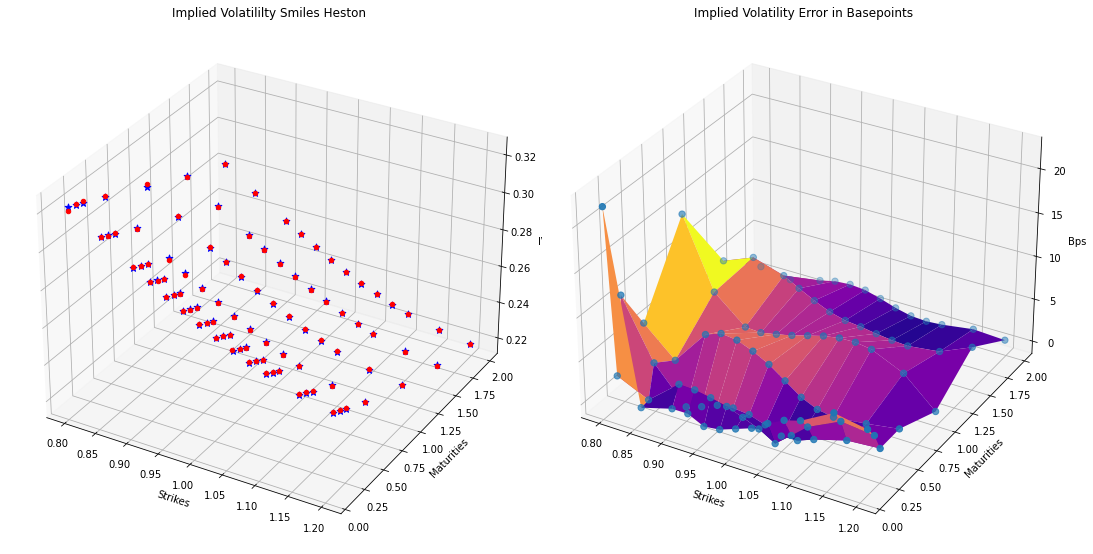

In [56]:
%matplotlib inline

# set up a figure twice as wide as it is tall
fig = plt.figure(figsize=(15,8))

# =============
# First subplot
# =============
# set up the axes for the first plot
ax = fig.add_subplot(1, 2, 1, projection='3d')

#surf = ax.plot_surface(strikes, YY, iv_market, rstride=1, cstride=1, cmap=cm.viridis,
#                       linewidth=0.5)
YY=np.array([[maturities[j]]*(len(strikes_new[0])) for j in range(7)])
ax.scatter(strikes_new, YY, iv_market,s=50,marker='*',color='blue',depthshade=False)
ax.scatter(strikes_new, YY, iv_calib_mc1_arr, s=20,marker='o',color='red',depthshade=False)


#ax.zaxis.set_rotate_label(True)
ax.set_xlabel('Strikes')
ax.set_ylabel('Maturities')
ax.set_zlabel('IV')

ax.set_title('Implied Volatililty Smiles Heston');


# ==============
# Second subplot
# ==============
# set up the axes for the second plot
ax = fig.add_subplot(1, 2, 2, projection='3d')
# plot a 3D wireframe like in the example mplot3d/wire3d_demo
ax.plot_surface(strikes_new, YY, np.abs(np.array(iv_calib_mc1_arr)-iv_market)*10000, rstride=1, cstride=1,cmap=cm.plasma,
                       linewidth=0.5)
ax.scatter(strikes_new, YY, np.abs(np.array(iv_calib_mc1_arr)-iv_market)*10000,s=40)

ax.set_xlabel('Strikes')
ax.set_ylabel('Maturities')
ax.set_zlabel('Bps')
ax.set_title('Implied Volatility Error in Basepoints');

#plt.savefig('IV_surface_Heston.png',dpi=150)
plt.tight_layout()
plt.show()

In [362]:
#os.chdir(r'C:\Users\Guido Gazzani\ucloud\Shared\SigSDEs_ucloud\Code_joint_calibration')
#np.save('ell_MC_HE_ipynb(2,4,2,1000000,config5).npy',res1['x'])
#np.save('pricescalib_MC_HE_ipynb(2,4,2,1000000,config5).npy',calibrated_prices1_arr)

# <font color='darkblue'> Configuration 3: </font>



In [30]:
strikes_new=np.array([np.array([0.8,0.85,0.9,0.925,0.95,0.975,1,1.025,1.05,1.075,1.1,1.15,1.2]) for k in range(7)])

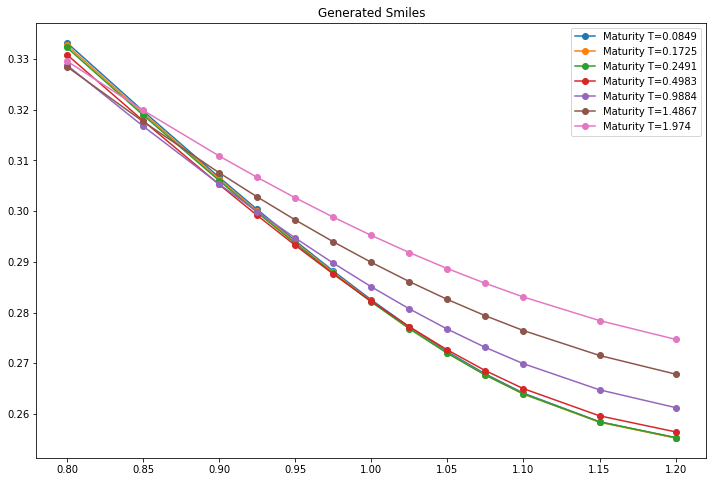

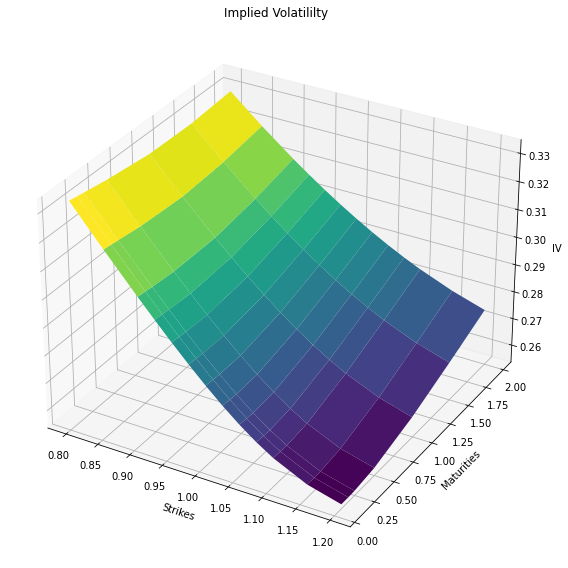

In [57]:
set_params={'alpha':0.5,'kappa':0.2,'theta':0.3,'rho':-0.5,'v0':0.08}
prices, iv= get_iv_Heston_by_params(set_params,strikes_new,maturities,S0,len(strikes_new[0]))
iv_market=np.array(np.split(iv,len(maturities)))
prices_market=np.array(np.split(prices,len(maturities)))

flat_normal_weights, norm_vegas=get_vegas(maturities, strikes_new, S0, iv_market, False)

In [42]:
os.chdir(r'C:\Users\Guido Gazzani\ucloud\Shared\SigSDEs_ucloud\Code_real_data\Cluster_files')
arr_dfs_by_mat=np.load('arr_dfs_by_mat((7, 1000000, 13)).npy')

n=2
d=2
D=1
initial_price=1
Premium=prices_market.flatten()
l_initial=np.random.uniform(-0.1,0.1,int(((d+1)**(n+1)-1)*D/d))


tensor_sigsde_at_mat=np.tensordot(arr_dfs_by_mat,l_initial,axes=1) #computes the value S_T(ell) for all mat for a fixed ell


def obj_MC_tensor(l):
    
    tensor_sigsde_at_mat=np.tensordot(arr_dfs_by_mat,l,axes=1)+initial_price #veloce
    
       # this part computes the monte carlo prices of the calls ---> output: mc_payoff_arr (quite fast)
    pay=[]
    for K in strikes_new[0]:
        matrix_big=[]
        for j in range(len(maturities)):
            payff=np.maximum(0, tensor_sigsde_at_mat[j] - K)
            matrix_big.append(payff)
        matrix=np.array(matrix_big)
        pay.append(np.mean(matrix,axis=1))
    mc_payoff_arr=np.array(pay).transpose().flatten()
    
    for k in range(1):
        print('One step completed')
    return np.sqrt(flat_normal_weights)*(mc_payoff_arr-Premium)



In [43]:
for t in tqdm(range(1)): 
    l_initial=np.random.uniform(-0.1,0.1,int(((d+1)**(n+1)-1)*D/d))
    res1 = least_squares(obj_MC_tensor, l_initial,loss='linear')

#np.save(f'ell_MC_HE({n},{m},{d},{rho},{MC_number},{initial_price}).npy',res1['x'])


def get_mc_all_mat_tensor(l):
    tensor_sigsde_at_mat=np.tensordot(arr_dfs_by_mat,l,axes=1)+initial_price
    pay=[]
    for K in strikes_new[0]:
        matrix_big=[]
        for j in range(len(maturities)):
            payff=np.maximum(0, tensor_sigsde_at_mat[j] - K)
            matrix_big.append(payff)
        matrix=np.array(matrix_big)
        pay.append(np.mean(matrix,axis=1))
    mc_payoff_arr=np.array(pay).transpose().flatten()
    return mc_payoff_arr



calibrated_prices=get_mc_all_mat_tensor(res1['x'])
#np.save(f'calibrated_prices_MC_HE({n},{MC_number},{N},{rho},{initial_price})',calibrated_prices)


  0%|          | 0/1 [00:00<?, ?it/s]

One step completed
One step completed
One step completed
One step completed
One step completed
One step completed
One step completed
One step completed
One step completed
One step completed
One step completed
One step completed
One step completed
One step completed
One step completed
One step completed
One step completed
One step completed
One step completed
One step completed
One step completed
One step completed
One step completed
One step completed
One step completed
One step completed
One step completed
One step completed
One step completed
One step completed
One step completed
One step completed
One step completed
One step completed
One step completed
One step completed
One step completed
One step completed
One step completed
One step completed
One step completed
One step completed
One step completed
One step completed
One step completed
One step completed
One step completed
One step completed
One step completed
One step completed
One step completed
One step completed
One step com

One step completed
One step completed
One step completed
One step completed
One step completed
One step completed
One step completed
One step completed
One step completed
One step completed
One step completed
One step completed
One step completed
One step completed
One step completed
One step completed
One step completed
One step completed
One step completed
One step completed
One step completed
One step completed
One step completed
One step completed
One step completed
One step completed
One step completed
One step completed
One step completed
One step completed
One step completed
One step completed
One step completed
One step completed
One step completed
One step completed
One step completed
One step completed
One step completed
One step completed
One step completed
One step completed
One step completed
One step completed
One step completed
One step completed
One step completed
One step completed
One step completed
One step completed
One step completed
One step completed
One step com

In [58]:
calibrated_prices=get_mc_all_mat_tensor(res1['x'])

In [59]:
norm_strikes=strikes_new
calibrated_prices1_arr=np.array(np.split(calibrated_prices,len(maturities)))

iv_calib_mc1=[]

for j in range(len(maturities)):
    for k in range(len(strikes_new[0])):
        iv_calib_mc1.append(implied_vol_minimize(calibrated_prices1_arr[j,k], 1, norm_strikes[j][k], maturities[j], 0, payoff="call", disp=True))
        


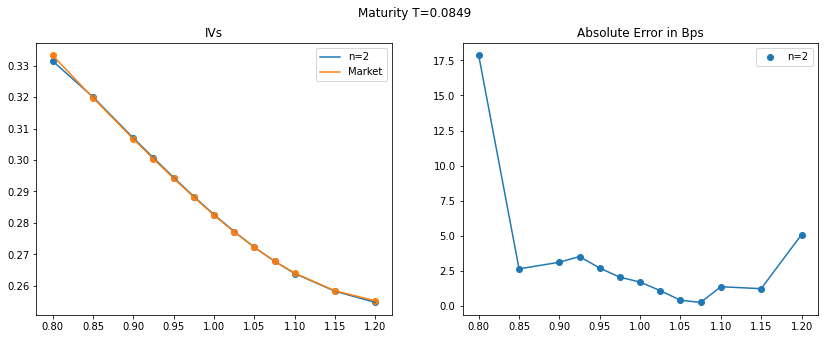

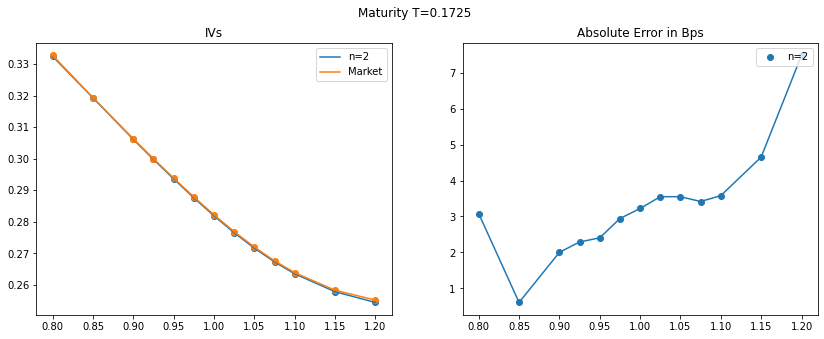

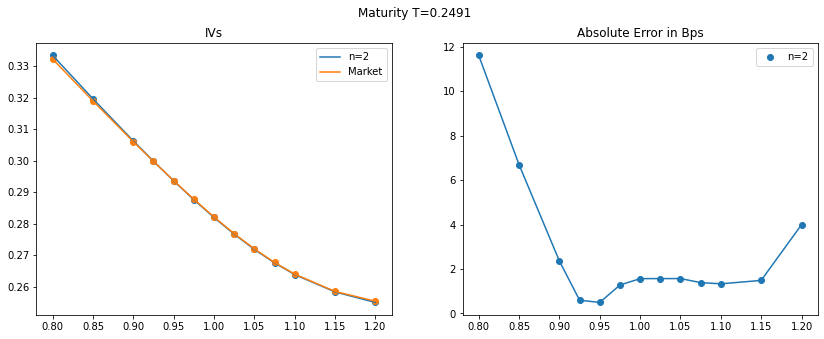

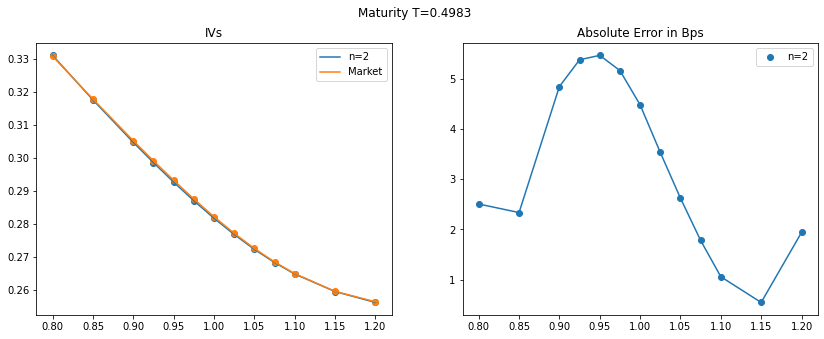

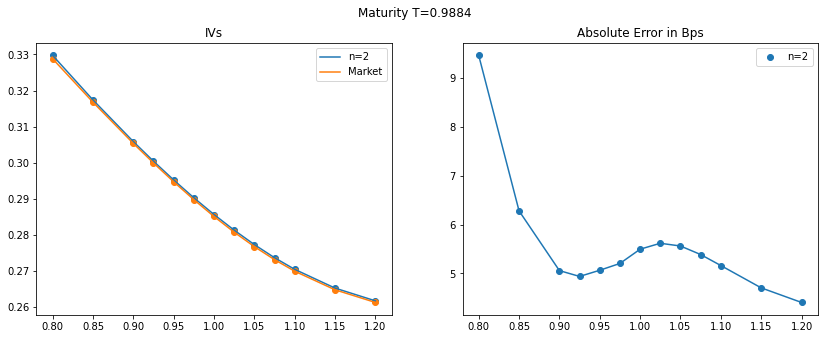

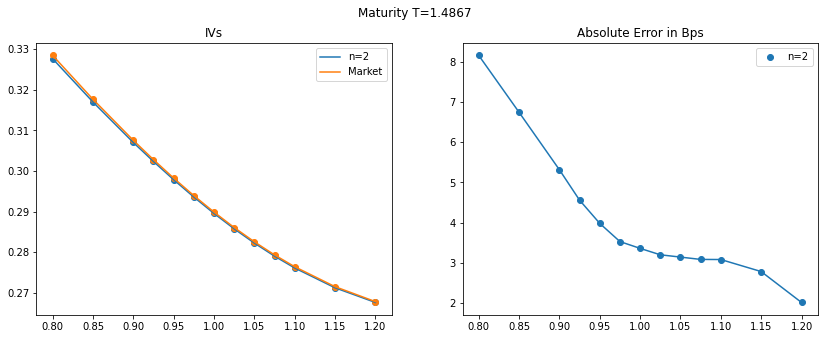

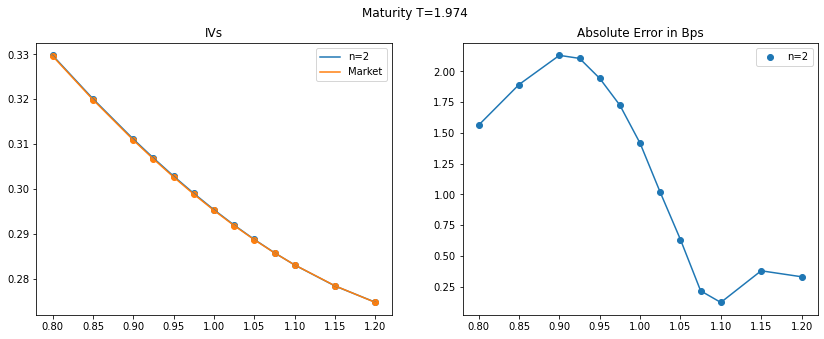

In [60]:
iv_calib_mc1_arr=np.array(np.split(np.array(iv_calib_mc1),len(maturities)))


for j in range(len(maturities)):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
    fig.suptitle('Maturity T={}'.format(round(maturities[j],4)))
    ax1.plot(strikes_new[j], iv_calib_mc1_arr[j],label='n=2')
    ax1.scatter(strikes_new[j], iv_calib_mc1_arr[j])
    ax1.plot(strikes_new[j], iv_market[j],label='Market')
    ax1.scatter(strikes_new[j], iv_market[j])
    ax2.plot(strikes_new[j],np.abs(iv_calib_mc1_arr[j]-iv_market[j])*10000)
    ax2.scatter(strikes_new[j],np.abs(iv_calib_mc1_arr[j]-iv_market[j])*10000,label='n=2')
    
    
    ax1.legend(loc='upper right')
    ax2.legend(loc='upper right')
    
    ax1.set_title('IVs')
    ax2.set_title('Absolute Error in Bps')
    
    plt.show()


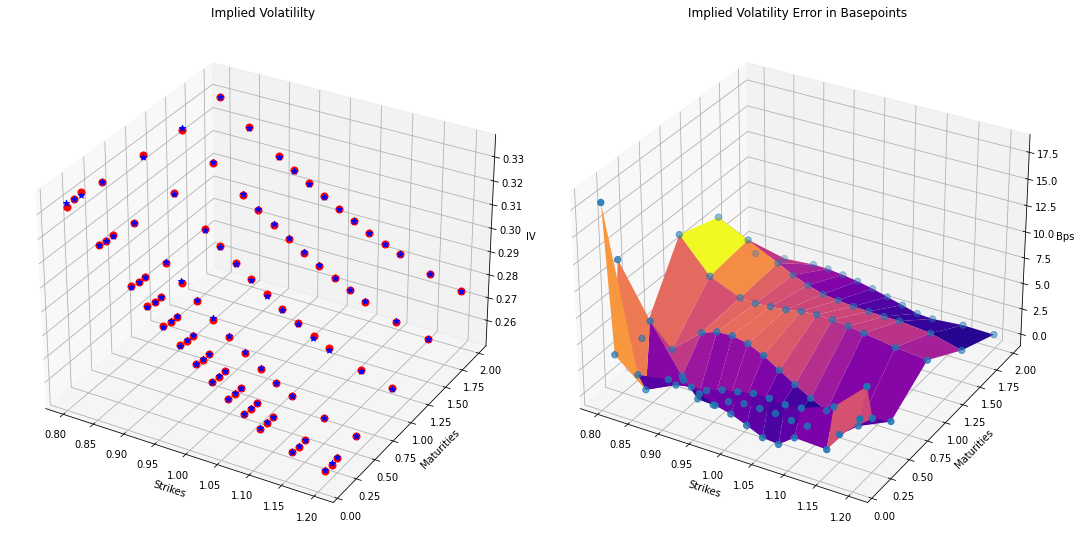

In [64]:
 
%matplotlib inline

# set up a figure twice as wide as it is tall
fig = plt.figure(figsize=(15,8))

# =============
# First subplot
# =============
# set up the axes for the first plot
ax = fig.add_subplot(1, 2, 1, projection='3d')

#surf = ax.plot_surface(strikes, YY, iv_market, rstride=1, cstride=1, cmap=cm.viridis,
#                       linewidth=0.5)
YY=np.array([[maturities[j]]*(len(strikes_new[0])) for j in range(7)])
ax.scatter(strikes_new, YY, iv_market,s=40,marker='*',color='blue',depthshade=False)
ax.scatter(strikes_new, YY, iv_calib_mc1_arr, s=50,marker='o',color='red',depthshade=False)


#ax.zaxis.set_rotate_label(True)
ax.set_xlabel('Strikes')
ax.set_ylabel('Maturities')
ax.set_zlabel('IV')

ax.set_title('Implied Volatililty');


# ==============
# Second subplot
# ==============
# set up the axes for the second plot
ax = fig.add_subplot(1, 2, 2, projection='3d')
# plot a 3D wireframe like in the example mplot3d/wire3d_demo
ax.plot_surface(strikes_new, YY, np.abs(np.array(iv_calib_mc1_arr)-iv_market)*10000, rstride=1, cstride=1,cmap=cm.plasma,
                       linewidth=0.5)
ax.scatter(strikes_new, YY, np.abs(np.array(iv_calib_mc1_arr)-iv_market)*10000,s=40)

ax.set_xlabel('Strikes')
ax.set_ylabel('Maturities')
ax.set_zlabel('Bps')
ax.set_title('Implied Volatility Error in Basepoints');

plt.savefig('IV_surface_Heston2.png',dpi=150)
plt.tight_layout()
plt.show()

